## Figure 2: Performance of the full perturbative error mitigation 

We will show the performance of the _general_ truncation scheme to recover the full bitstring distribution, as a function of cutoff weight $w$.

In [1]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1

env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import utils
import response_matrix

In [3]:
import itertools

In [4]:
# Utilities for making probability distributions

def make_uniform(n):
    """Make the uniform distribution over n qubits."""
    d = 1 << n
    return np.ones(d) / d

def make_random(n):
    d = 1 << n
    out = np.random.rand(d)
    return out / out.sum()


In [5]:
import multiprocessing
import concurrent.futures as cf
from tqdm import tqdm

imported_tqdm = True

def parallel_run(func, run_list, n_workers, func_args=(), func_kwargs={},
                 input_as_kwargs=False, error_counter=0, retry_switch=True,
                 retry_max=5, processor_no_limited=False, use_tqdm=False,
                 thread_pool=False):
    '''
    Parameters
    ----------
    func                    : function
    run_list                : list
    n_workers               : int
    func_args               : tuple, optional
    func_kwargs             : dict, optional
    input_as_kwargs         : {True, False (default)}, optional
    retry_switch            : {True (default), False}, optional
    retry_max               : int, optional
        default: 5
    processor_no_limited    : {True, False (default)}, optional
    use_tqdm                : {True, False (default)}, optional
    thread_pool             : {True, False (default)}, optional
    error_counter           : int, optional
        internal use only
        default: 0
    '''
    if processor_no_limited:
        n_workers_use = min(multiprocessing.cpu_count(), n_workers)
    else:
        n_workers_use = n_workers

    if error_counter >= retry_max:
        raise RuntimeError('Hit max retry')

    u_tqdm = False
    if use_tqdm:
        if imported_tqdm:
            u_tqdm = True
        else:
            warnings.warn('\'tqdm\' not installed.')

    retry_id_list = []
    if n_workers_use == 1:
        if u_tqdm:
            if input_as_kwargs:
                result = [func(*func_args, **x, **func_kwargs)
                          for x in tqdm(run_list)]
            else:
                result = [func(x, *func_args, **func_kwargs)
                          for x in tqdm(run_list)]
        else:
            if input_as_kwargs:
                result = [func(*func_args, **x, **func_kwargs)
                          for x in run_list]
            else:
                result = [func(x, *func_args, **func_kwargs)
                          for x in run_list]
    else:
        if not thread_pool:
            ex = cf.ProcessPoolExecutor(max_workers=n_workers_use)
        else:
            ex = cf.ThreadPoolExecutor(max_workers=n_workers_use)

        if input_as_kwargs:
            job_list = [ex.submit(func, *func_args, **x, **func_kwargs)
                        for x in run_list]
        else:
            job_list = [ex.submit(func, x, *func_args, **func_kwargs)
                        for x in run_list]

        if u_tqdm:
            tqdm_kwargs = {
                'total': len(job_list),
                'unit_scale': True
            }
            for f in tqdm(cf.as_completed(job_list), **tqdm_kwargs):
                pass
        ex.shutdown(wait=True)

        result = [0] * len(job_list)
        for j, job in enumerate(job_list):
            if retry_switch:
                try:
                    result[j] = job.result()
                except Exception as e:
                    msg = 'parallel_run retry ' + str(error_counter)
                    msg += ' for item ' + str(j) + ' with error: ' + str(e)
                    print(msg)
                    retry_id_list.append(j)
            else:
                try:
                    result[j] = job.result()
                except Exception as e:
                    msg = 'item ' + str(j) + ' with error: ' + str(e)
                    raise RuntimeError(msg)

    # retry for pipelines which return error
    # retry intention is that error is due to simulator overcrowding which
    # rarely happends
    if len(retry_id_list) != 0:
        error_counter += 1
        retry_list = [run_list[j] for j in retry_id_list]
        retry_result = parallel_run(func, retry_list, n_workers, func_args,
                                    func_kwargs, error_counter)
        for j, retry_id in enumerate(retry_id_list):
            result[retry_id] = retry_result[j]
    return(result)

### Compute the corrected prob distribution using Algorithm 1

### Construct test R

We enforce that $R$ has a tensor structure so that multi-flip events are necessarily exponentially suppressed in weight change of bitstring.

In [6]:
# Arrays of q(0|1) and q(1|0)
q01_arr = [0.09, .07, 0.12, 0.08, 0.11]
q10_arr = [0.04, .03, .05, 0.04, 0.02]
R = response_matrix.Rmatrix(q01_arr, q10_arr)
Rinv = np.linalg.inv(R)

Text(0.5, 1.0, 'Initial comparison')

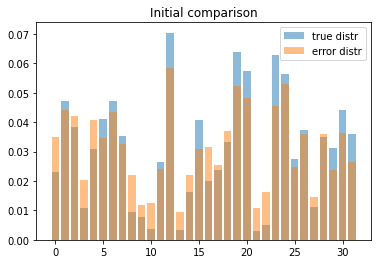

In [7]:
n = len(q01_arr)
x = np.arange(1 << n)
p_true = make_random(n)
p_prime = R @ p_true

plt.bar(x, p_true, alpha=0.5, label="true distr")
plt.bar(x, p_prime, alpha=0.5, label="error distr")
plt.legend()
plt.title("Initial comparison")

## Two experiments

1. First experiment: Fix $q$, then plot $d(p, \tilde{p})$ as a function of $w$ for changing no. qubits
2. Second exeriment: Fix $n$, then plot $d(p, \tilde{p})$ as a function of $q$ for changing w cutoff


In [8]:
def trace_dist(a, b):
    # use trace distance for comparing full distributions
    return abs(a - b).sum()

# First experiment
wvals = [1, 2, 3, 4]
nqubits_lst = [4, 6, 8, 10, 12]
qfixed = .06

def slice_for_Rj(n, j):
    """Construct an array slice for all indices corresponding to an Rj cut.

    TODO: could be more efficient taking
    Args:
        n: number of bits
        j: "order" of R_j to compute
    Returns:
        slices: tuple(np.ndarray, np.ndarray) of zipped (x,y) corrdinates, such
            that R[slices] = R_j
    """
    out = []
    d = 1 << n
    for i in range(d):
        for k in range(d):
            if k < i:
                continue
            if utils.distance(i, k) == j:
                out.append((i,k))
    out = np.asarray(list(zip(*out)))
    slices = tuple(np.hstack((out, out[::-1,:])))
    return slices

def invert_pfull_truncated_2(R, p_prime, w1, w2=None):
    """Compute $R^{-1}p'$ using a series truncation.

    Args:
        R: Baseline response matrix.
        p_prime: Probability distribution representing observations WITH errors
        w1: Cutoff for the _infinite_ series for computing A^{-1}
        w2: Cutoff for the decomposition of R into {R_j: j=1, ..., w2}

    Returns:
        p_fixed: output distribution acheived by inverting R up to truncation
            (w1, w2).
    """

    if w2 is None:
        w2 = w1

    d = R.shape[0]
    n = int(np.log2(d))

    R_truncated = np.zeros((d, d), dtype=float)
    for j in range(0, w2 + 1):
        coor = slice_for_Rj(n, j)
        R_truncated[coor] = R[coor]

    p_fixed = np.linalg.inv(R_truncated).dot(p_prime)
    return p_fixed

In [ ]:
# Baseline contains the uncorrected distribution comparison to ptrue
baseline = np.zeros(len(nqubits_lst))
# Outcomes contain truncated result comparisons
outcomes = np.zeros((len(wvals), len(nqubits_lst))) # rows correspond to w=1,2...

for j, n_qubits in enumerate(nqubits_lst):
    # Generate response matrix and artificial readout error
    R = response_matrix.generate_characteristic_R(qfixed, n_qubits)
#     Rinv = np.linalg.inv(R)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true
    
    # Full distribution correction
    baseline[j] = trace_dist(p_prime, p_true)
    for k, w in enumerate(wvals):
        p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
        outcomes[k,j] = trace_dist(p_fixed, p_true)

np.save('w_scaling_outcomes.npy', outcomes)
np.save('w_scaling_baseline.npy', baseline)

In [ ]:
# Second experiment
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

ntrials = 8
qvals = np.linspace(0.01, 0.15, 16)
n_qubits = 10

# Outcomes contain truncated result comparisons
q_outcomes = np.zeros((len(wvals) + 1, len(qvals), ntrials)) # rows correspond to w=0, 1,2...

for trial in range(ntrials):
    for j, qmax in enumerate(qvals):
        # Generate response matrix and artificial readout error
        R = response_matrix.generate_characteristic_R(qmax, n_qubits)
        Rinv = np.linalg.inv(R)
        p_true = make_random(n_qubits)
        p_prime = R @ p_true

        # Full distribution correction
        q_outcomes[0, j, trial] = trace_dist(p_prime, p_true)
        for k, w in enumerate(wvals):
            p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
            q_outcomes[k + 1,j, trial] = trace_dist(p_fixed, p_true)

np.save("{}qubits_scaling_results.npy".format(n_qubits), q_outcomes)

In [ ]:
# Second experiment
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

def run_function(val_in, n_qubits):
    qmax, trial = val_in
    R = response_matrix.generate_characteristic_R(qmax, n_qubits)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true

    # Full distribution correction
    q_outcome = []
    q_outcome.append(trace_dist(p_prime, p_true))
    for k, w in enumerate(wvals):
        p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
        q_outcome.append(trace_dist(p_fixed, p_true))
    return np.array(q_outcome)

ntrials = 20
qvals = np.linspace(0.01, 0.2, 21)
# n_qubits = 4

for n_qubits in list(range(6, 14, 2)):
    run_list = list(itertools.product(qvals, range(ntrials)))
    outputs = parallel_run(
        run_function, run_list, n_workers=16, retry_switch=False, use_tqdm=True,
        func_kwargs=dict(n_qubits=n_qubits))

    # Outcomes contain truncated result comparisons
    q_outcomes = np.zeros((len(qvals), ntrials, len(wvals) + 1)) # rows correspond to w=0, 1,2...

    run_list_2 = list(itertools.product(range(len(qvals)), range(ntrials)))
    for n, val_in in enumerate(run_list_2):
        j, trial = val_in
        q_outcomes[j, trial] = outputs[n]

    q_outcomes = np.swapaxes(np.swapaxes(q_outcomes, 2, 1), 1, 0)
    np.save("{}qubits_scaling_results_2.npy".format(n_qubits), q_outcomes)

In [ ]:
# Second experiment
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

def run_function(val_in, n_qubits):
    qmax, trial = val_in
    qmax = 10* qmax / n_qubits
    R = response_matrix.generate_characteristic_R(qmax, n_qubits)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true

    # Full distribution correction
    q_outcome = []
    q_outcome.append(trace_dist(p_prime, p_true))
    for k, w in enumerate(wvals):
        p_fixed = invert_pfull_truncated_2(R, p_prime, w1=w, w2=w)
        q_outcome.append(trace_dist(p_fixed, p_true))
    return np.array(q_outcome)

ntrials = 20
qvals = np.linspace(0.01, 0.2, 21)
# n_qubits = 4

for n_qubits in list(range(6, 14, 2)):
    run_list = list(itertools.product(qvals, range(ntrials)))
    outputs = parallel_run(
        run_function, run_list, n_workers=64, retry_switch=False, use_tqdm=True,
        func_kwargs=dict(n_qubits=n_qubits))

    # Outcomes contain truncated result comparisons
    q_outcomes = np.zeros((len(qvals), ntrials, len(wvals) + 1)) # rows correspond to w=0, 1,2...

    run_list_2 = list(itertools.product(range(len(qvals)), range(ntrials)))
    for n, val_in in enumerate(run_list_2):
        j, trial = val_in
        q_outcomes[j, trial] = outputs[n]

    q_outcomes = np.swapaxes(np.swapaxes(q_outcomes, 2, 1), 1, 0)
    np.save("{}qubits_scaling_results_2a.npy".format(n_qubits), q_outcomes)

In [38]:
# Second experiment
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

def run_function(val_in, n_qubits):
    qmax, trial = val_in
    qmax = 10* qmax / n_qubits
    R = response_matrix.generate_characteristic_R(qmax, n_qubits)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true

    # Full distribution correction
    q_outcome = []
    q_outcome.append(trace_dist(p_prime, p_true))
    for k, w in enumerate(wvals):
        p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
        q_outcome.append(trace_dist(p_fixed, p_true))
    return np.array(q_outcome)

ntrials = 20
qvals = np.linspace(0.01, 0.2, 21)
# n_qubits = 4

for n_qubits in list(range(6, 13, 1)):
    run_list = list(itertools.product(qvals, range(ntrials)))
    outputs = parallel_run(
        run_function, run_list, n_workers=64, retry_switch=False, use_tqdm=True,
        func_kwargs=dict(n_qubits=n_qubits))

    # Outcomes contain truncated result comparisons
    q_outcomes = np.zeros((len(qvals), ntrials, len(wvals) + 1)) # rows correspond to w=0, 1,2...

    run_list_2 = list(itertools.product(range(len(qvals)), range(ntrials)))
    for n, val_in in enumerate(run_list_2):
        j, trial = val_in
        q_outcomes[j, trial] = outputs[n]

    q_outcomes = np.swapaxes(np.swapaxes(q_outcomes, 2, 1), 1, 0)
    np.save("{}qubits_scaling_results_3.npy".format(n_qubits), q_outcomes)

100%|██████████| 420/420 [55:19<00:00, 2.64s/it]   


In [11]:
# Second experiment
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

def run_function(val_in, n_qubits):
    qmax, trial = val_in
    qmax = 10* qmax / n_qubits
    R = response_matrix.generate_characteristic_R(qmax, n_qubits)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true

    # Full distribution correction
    q_outcome = []
    q_outcome.append(trace_dist(p_prime, p_true))
    for k, w in enumerate(wvals):
        p_fixed = invert_pfull_truncated_2(R, p_prime, w1=w, w2=w)
        q_outcome.append(trace_dist(p_fixed, p_true))
    return np.array(q_outcome)

ntrials = 20
qvals = np.linspace(0.04, 0.8, 20)
# n_qubits = 4

for n_qubits in list(range(6, 14, 2)):
    run_list = list(itertools.product(qvals, range(ntrials)))
    outputs = parallel_run(
        run_function, run_list, n_workers=64, retry_switch=False, use_tqdm=True,
        func_kwargs=dict(n_qubits=n_qubits))

    # Outcomes contain truncated result comparisons
    q_outcomes = np.zeros((len(qvals), ntrials, len(wvals) + 1)) # rows correspond to w=0, 1,2...

    run_list_2 = list(itertools.product(range(len(qvals)), range(ntrials)))
    for n, val_in in enumerate(run_list_2):
        j, trial = val_in
        q_outcomes[j, trial] = outputs[n]

    q_outcomes = np.swapaxes(np.swapaxes(q_outcomes, 2, 1), 1, 0)
    np.save("{}qubits_scaling_results_3a.npy".format(n_qubits), q_outcomes)

100%|██████████| 400/400 [44:24<00:00, 4.68s/it]    


In [9]:
# Second experiment
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

def run_function(val_in, n_qubits):
    qmax, trial = val_in
    qmax = 10* qmax / n_qubits
    R = response_matrix.generate_characteristic_R(qmax, n_qubits)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true

    # Full distribution correction
    q_outcome = []
    q_outcome.append(trace_dist(p_prime, p_true))
    for k, w in enumerate(wvals):
        p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
        q_outcome.append(trace_dist(p_fixed, p_true))
    return np.array(q_outcome)

ntrials = 40
qvals = np.linspace(0.005 , 0.2, 40)
# n_qubits = 4

for n_qubits in list(range(6, 14, 2)):
    run_list = list(itertools.product(qvals, range(ntrials)))
    outputs = parallel_run(
        run_function, run_list, n_workers=64, retry_switch=False, use_tqdm=True,
        func_kwargs=dict(n_qubits=n_qubits))

    # Outcomes contain truncated result comparisons
    q_outcomes = np.zeros((len(qvals), ntrials, len(wvals) + 1)) # rows correspond to w=0, 1,2...

    run_list_2 = list(itertools.product(range(len(qvals)), range(ntrials)))
    for n, val_in in enumerate(run_list_2):
        j, trial = val_in
        q_outcomes[j, trial] = outputs[n]

    q_outcomes = np.swapaxes(np.swapaxes(q_outcomes, 2, 1), 1, 0)
    np.save("{}qubits_scaling_results_4.npy".format(n_qubits), q_outcomes)

100%|██████████| 1.60k/1.60k [00:03<00:00, 527it/s]
100%|██████████| 1.60k/1.60k [00:55<00:00, 8.71it/s] 
100%|██████████| 1.60k/1.60k [13:02<00:00, 1.46it/s]  
 18%|█▊        | 296/1.60k [1:03:19<5:03:51, 14.0s/it]Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/concurrent/futures/process.py", line 295, in _queue_management_worker
    shutdown_worker()
  File "/usr/lib/python3.6/concurrent/futures/process.py", line 253, in shutdown_worker
    call_queue.put_nowait(None)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 129, in put_nowait
    return self.put(obj, False)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 83, in put
    raise Full
queue.Full

100%|██████████| 1.60k/1.60k [1:03:19<00:00, 2.37s/it]


RuntimeError: item 39 with error: index 2100598 is out of bounds for axis 0 with size 4096

In [9]:
# Second experiment
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

def run_function(val_in, n_qubits):
    qmax, trial = val_in
    qmax = 10* qmax / n_qubits
    R = response_matrix.generate_characteristic_R(qmax, n_qubits)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true

    # Full distribution correction
    q_outcome = []
    q_outcome.append(trace_dist(p_prime, p_true))
    for k, w in enumerate(wvals):
        p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
        q_outcome.append(trace_dist(p_fixed, p_true))
    return np.array(q_outcome)

ntrials = 40
qvals = np.linspace(0.005 , 0.2, 40)
# n_qubits = 4

for n_qubits in list(range(12, 14, 2)):
    run_list = list(itertools.product(qvals, range(ntrials)))
    outputs = parallel_run(
        run_function, run_list, n_workers=64, retry_switch=True, use_tqdm=True,
        func_kwargs=dict(n_qubits=n_qubits))

    # Outcomes contain truncated result comparisons
    q_outcomes = np.zeros((len(qvals), ntrials, len(wvals) + 1)) # rows correspond to w=0, 1,2...

    run_list_2 = list(itertools.product(range(len(qvals)), range(ntrials)))
    for n, val_in in enumerate(run_list_2):
        j, trial = val_in
        q_outcomes[j, trial] = outputs[n]

    q_outcomes = np.swapaxes(np.swapaxes(q_outcomes, 2, 1), 1, 0)
    np.save("{}qubits_scaling_results_4.npy".format(n_qubits), q_outcomes)

100%|██████████| 1.60k/1.60k [4:19:34<00:00, 7.14s/it]   


In [10]:
# Second experiment
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

def run_function(val_in, n_qubits):
    qmax, trial = val_in
    qmax = 10* qmax / n_qubits
    R = response_matrix.generate_characteristic_R(qmax, n_qubits)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true

    # Full distribution correction
    q_outcome = []
    q_outcome.append(trace_dist(p_prime, p_true))
    for k, w in enumerate(wvals):
        p_fixed = invert_pfull_truncated_2(R, p_prime, w1=w, w2=w)
        q_outcome.append(trace_dist(p_fixed, p_true))
    return np.array(q_outcome)

ntrials = 40
qvals = np.linspace(0.005 , 0.2, 40)
# n_qubits = 4

for n_qubits in list(range(6, 14, 2)):
    run_list = list(itertools.product(qvals, range(ntrials)))
    outputs = parallel_run(
        run_function, run_list, n_workers=64, retry_switch=True, use_tqdm=True,
        func_kwargs=dict(n_qubits=n_qubits))

    # Outcomes contain truncated result comparisons
    q_outcomes = np.zeros((len(qvals), ntrials, len(wvals) + 1)) # rows correspond to w=0, 1,2...

    run_list_2 = list(itertools.product(range(len(qvals)), range(ntrials)))
    for n, val_in in enumerate(run_list_2):
        j, trial = val_in
        q_outcomes[j, trial] = outputs[n]

    q_outcomes = np.swapaxes(np.swapaxes(q_outcomes, 2, 1), 1, 0)
    np.save("{}qubits_scaling_results_4a.npy".format(n_qubits), q_outcomes)

100%|██████████| 1.60k/1.60k [00:00<00:00, 2.45kit/s]
100%|██████████| 1.60k/1.60k [00:15<00:00, 103it/s] 
100%|██████████| 1.60k/1.60k [04:20<00:00, 6.18it/s] 
100%|██████████| 1.60k/1.60k [3:35:27<00:00, 4.32s/it]  


### result

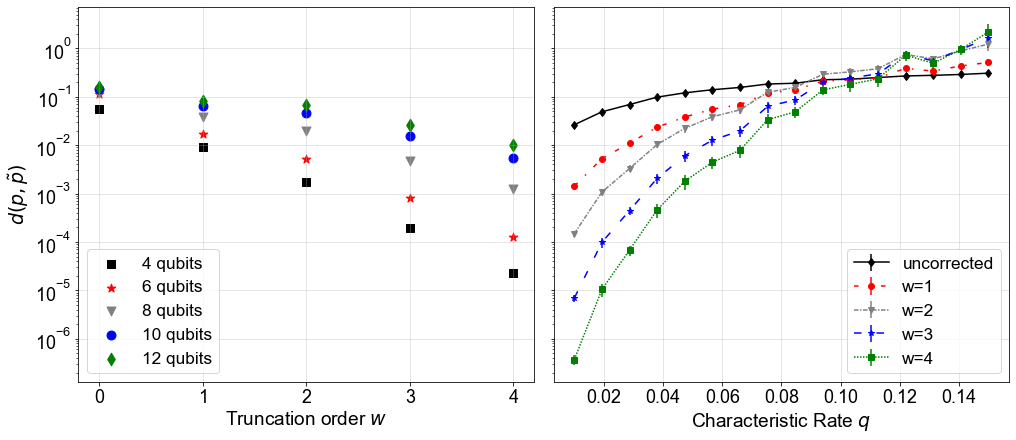

In [9]:
ntrials = 8
qvals = np.linspace(0.01, 0.15, 16)
n_qubits = 10

outcomes = np.load('w_scaling_outcomes.npy')
baseline = np.load('w_scaling_baseline.npy')
q_outcomes = np.load("{}qubits_scaling_results.npy".format(n_qubits))


plt.style.use('./style.mplstyle')
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True, sharey=True)


all_outcomes = np.vstack((baseline, outcomes))

x = np.asarray([0] + wvals)

leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = ['s', '*', 'v', 'o', 'd']
colors = ['k', 'r', 'gray', 'b', 'g']

# Full distr results
for j, y in enumerate(all_outcomes.T):
    axes[0].scatter(x, y, label=leglabs[j], marker=markers[j], s=80, c=colors[j])
    
# Ideally one could overlay a bound derived in the paper
# but unfortunately we've used two different error metrics (L2 vs. L1)...
# axes[0].scatter(x, (2 * qfixed) ** (x+1))

axes[0].set_ylabel(r"$d(p, \tilde{p})$")
axes[0].set_xticks(x)
axes[0].set_xticklabels(x)
axes[0].set_xlabel(r"Truncation order $w$")
# axes[0].set_title(r"$q=${}".format(qfixed))
axes[0].legend()


# Second figure: plot trace distance asfu of characteristic q
leglabels = ["uncorrected"] + [f"w={w}" for w in wvals]
linestyles = ["solid", (0, (3, 7, 1, 7)), (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (1, 1))]
markers_2 = list(reversed(markers)) # scramble these to avoid visual continuity

q_avg_outcomes = q_outcomes.mean(axis=2)
q_var_outcomes = q_outcomes.std(axis=2) / np.sqrt(ntrials) # "standard error" = SD / sqrt(ntrials)
# q_var_outcomes = q_outcomes.std(axis=2) # "standard error" = SD / sqrt(ntrials)
for j, y in enumerate(q_avg_outcomes):
    confidence = q_var_outcomes[j]
    axes[1].errorbar(qvals, y, yerr=confidence, label=leglabels[j], marker=markers_2[j], ls=linestyles[j], c=colors[j])

    
axes[1].set_xlabel(r"Characteristic Rate $q$")
axes[1].legend(leglabels)
axes[1].set_yticklabels(axes[0].get_yticklabels())

# Formatting for both
for ax in axes:
#     ax.set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
    ax.grid(True, alpha=0.4)
    ax.semilogy()


# fig.savefig("figures/figure2.pdf")

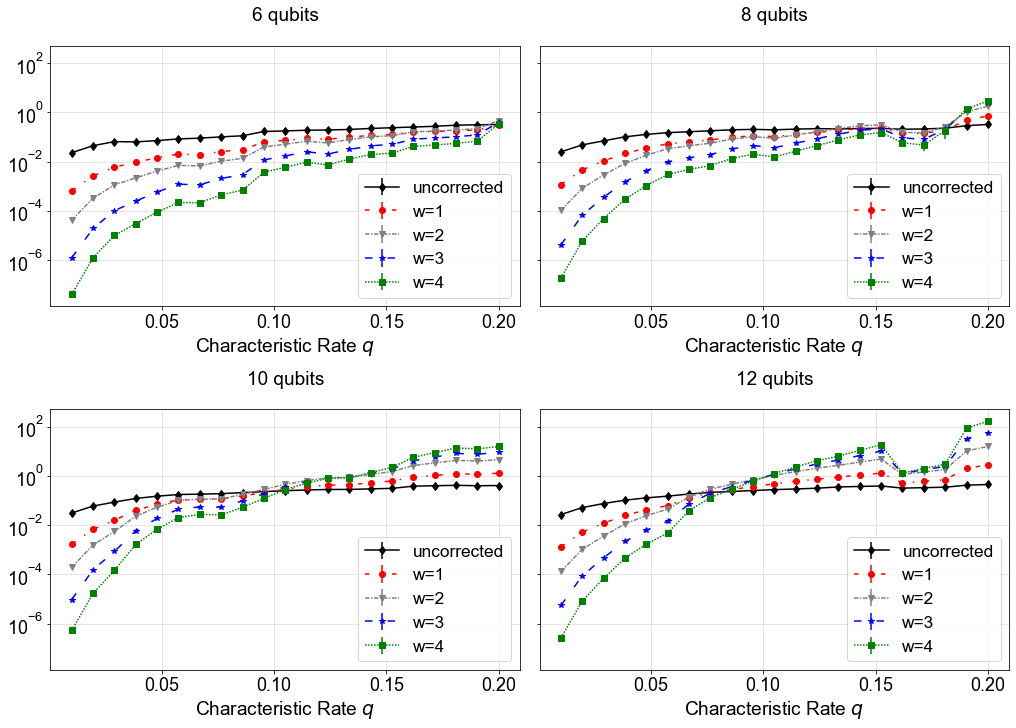

In [46]:
ntrials = 20
qvals = np.linspace(0.01, 0.2, 21)

plt.style.use('./style.mplstyle')
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True, sharey=True)

x = np.asarray([0] + wvals)

leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = ['s', '*', 'v', 'o', 'd']
colors = ['k', 'r', 'gray', 'b', 'g']

# Second figure: plot trace distance asfu of characteristic q
leglabels = ["uncorrected"] + [f"w={w}" for w in wvals]
linestyles = ["solid", (0, (3, 7, 1, 7)), (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (1, 1))]
markers_2 = list(reversed(markers)) # scramble these to avoid visual continuity

ax_list = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]
n_qubits_list = [6, 8, 10, 12]

for n_qubits, ax in zip(n_qubits_list, ax_list):
    q_outcomes = np.load("{}qubits_scaling_results_2.npy".format(n_qubits))
    q_avg_outcomes = q_outcomes.mean(axis=2)
    q_var_outcomes = q_outcomes.std(axis=2) / np.sqrt(ntrials) # "standard error" = SD / sqrt(ntrials)
    # q_var_outcomes = q_outcomes.std(axis=2) # "standard error" = SD / sqrt(ntrials)
    for j, y in enumerate(q_avg_outcomes):
        confidence = q_var_outcomes[j]
        ax.errorbar(qvals, y, yerr=confidence, label=leglabels[j], marker=markers_2[j], ls=linestyles[j], c=colors[j])
    ax.set_title('{nq} qubits'.format(nq=n_qubits))

# Formatting for both
for ax in ax_list:
    ax.set_xlabel(r"Characteristic Rate $q$")
    ax.legend(leglabels)
    ax.grid(True, alpha=0.4)
    ax.semilogy()


# fig.savefig("figures/figure2.pdf")

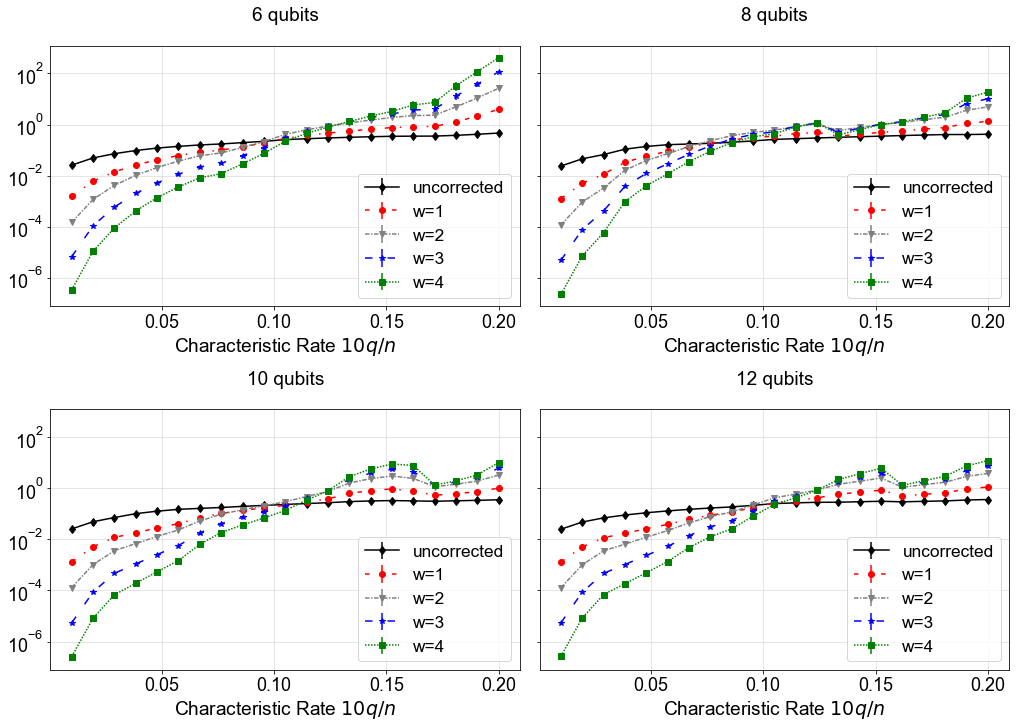

In [48]:
ntrials = 20
qvals = np.linspace(0.01, 0.2, 21)

plt.style.use('./style.mplstyle')
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True, sharey=True)

x = np.asarray([0] + wvals)

leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = ['s', '*', 'v', 'o', 'd']
colors = ['k', 'r', 'gray', 'b', 'g']

# Second figure: plot trace distance asfu of characteristic q
leglabels = ["uncorrected"] + [f"w={w}" for w in wvals]
linestyles = ["solid", (0, (3, 7, 1, 7)), (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (1, 1))]
markers_2 = list(reversed(markers)) # scramble these to avoid visual continuity

ax_list = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]
n_qubits_list = [6, 8, 10, 12]

for n_qubits, ax in zip(n_qubits_list, ax_list):
    q_outcomes = np.load("{}qubits_scaling_results_3.npy".format(n_qubits))
    q_avg_outcomes = q_outcomes.mean(axis=2)
    q_var_outcomes = q_outcomes.std(axis=2) / np.sqrt(ntrials) # "standard error" = SD / sqrt(ntrials)
    # q_var_outcomes = q_outcomes.std(axis=2) # "standard error" = SD / sqrt(ntrials)
    for j, y in enumerate(q_avg_outcomes):
        confidence = q_var_outcomes[j]
        ax.errorbar(qvals, y, yerr=confidence, label=leglabels[j], marker=markers_2[j], ls=linestyles[j], c=colors[j])
    ax.set_title('{nq} qubits'.format(nq=n_qubits))

# Formatting for both
for ax in ax_list:
    ax.set_xlabel(r"Characteristic Rate $10 q / n$")
    ax.legend(leglabels)
    ax.grid(True, alpha=0.4)
    ax.semilogy()


# fig.savefig("figures/figure2.pdf")

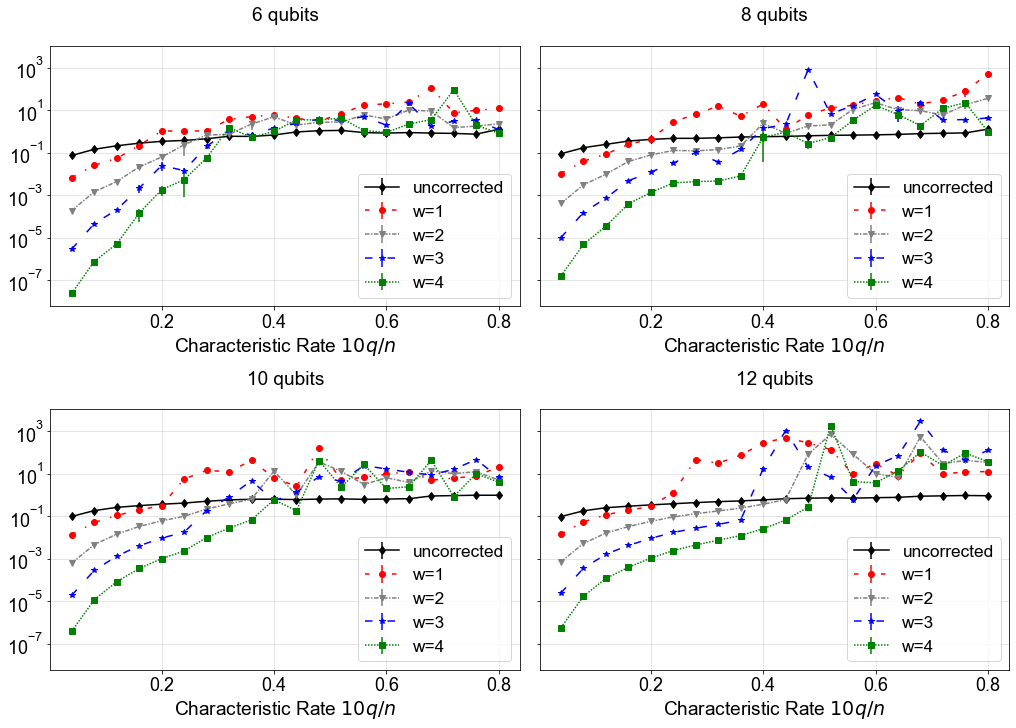

In [13]:
ntrials = 20
qvals = np.linspace(0.04, 0.8, 20)

plt.style.use('./style.mplstyle')
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True, sharey=True)

x = np.asarray([0] + wvals)

leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = ['s', '*', 'v', 'o', 'd']
colors = ['k', 'r', 'gray', 'b', 'g']

# Second figure: plot trace distance asfu of characteristic q
leglabels = ["uncorrected"] + [f"w={w}" for w in wvals]
linestyles = ["solid", (0, (3, 7, 1, 7)), (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (1, 1))]
markers_2 = list(reversed(markers)) # scramble these to avoid visual continuity

ax_list = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]
n_qubits_list = [6, 8, 10, 12]

for n_qubits, ax in zip(n_qubits_list, ax_list):
    q_outcomes = np.load("{}qubits_scaling_results_3a.npy".format(n_qubits))
    q_avg_outcomes = q_outcomes.mean(axis=2)
    q_var_outcomes = q_outcomes.std(axis=2) / np.sqrt(ntrials) # "standard error" = SD / sqrt(ntrials)
    # q_var_outcomes = q_outcomes.std(axis=2) # "standard error" = SD / sqrt(ntrials)
    for j, y in enumerate(q_avg_outcomes):
        confidence = q_var_outcomes[j]
        ax.errorbar(qvals, y, yerr=confidence, label=leglabels[j], marker=markers_2[j], ls=linestyles[j], c=colors[j])
    ax.set_title('{nq} qubits'.format(nq=n_qubits))

# Formatting for both
for ax in ax_list:
    ax.set_xlabel(r"Characteristic Rate $10 q / n$")
    ax.legend(leglabels)
    ax.grid(True, alpha=0.4)
    ax.semilogy()


# fig.savefig("figures/figure2.pdf")

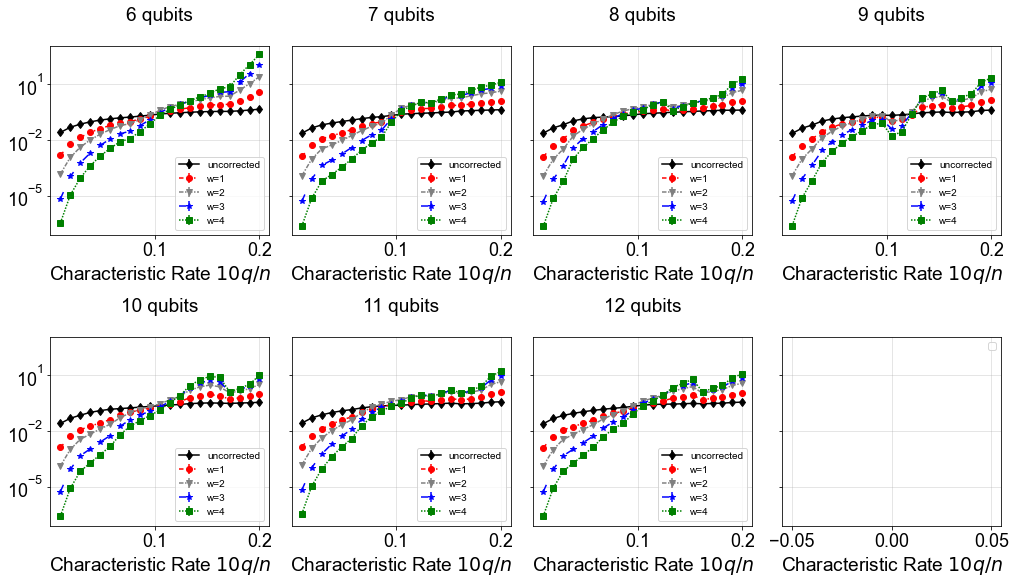

In [43]:
ntrials = 20
qvals = np.linspace(0.01, 0.2, 21)

plt.style.use('./style.mplstyle')
fig, axes = plt.subplots(2, 4, figsize=(14, 8), constrained_layout=True, sharey=True)

x = np.asarray([0] + wvals)

leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = ['s', '*', 'v', 'o', 'd']
colors = ['k', 'r', 'gray', 'b', 'g']

# Second figure: plot trace distance asfu of characteristic q
leglabels = ["uncorrected"] + [f"w={w}" for w in wvals]
linestyles = ["solid", (0, (3, 7, 1, 7)), (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (1, 1))]
markers_2 = list(reversed(markers)) # scramble these to avoid visual continuity

ax_list = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3]]
n_qubits_list = [6, 7, 8, 9, 10, 11, 12]

for n_qubits, ax in zip(n_qubits_list, ax_list):
    q_outcomes = np.load("{}qubits_scaling_results_3.npy".format(n_qubits))
    q_avg_outcomes = q_outcomes.mean(axis=2)
    q_var_outcomes = q_outcomes.std(axis=2) / np.sqrt(ntrials) # "standard error" = SD / sqrt(ntrials)
    # q_var_outcomes = q_outcomes.std(axis=2) # "standard error" = SD / sqrt(ntrials)
    for j, y in enumerate(q_avg_outcomes):
        confidence = q_var_outcomes[j]
        ax.errorbar(qvals, y, yerr=confidence, label=leglabels[j], marker=markers_2[j], ls=linestyles[j], c=colors[j])
    ax.set_title('{nq} qubits'.format(nq=n_qubits))

# Formatting for both
for ax in ax_list:
    ax.set_xlabel(r"Characteristic Rate $10 q / n$")
    ax.legend(leglabels, fontsize=10)
    ax.grid(True, alpha=0.4)
    ax.semilogy()


# fig.savefig("figures/figure2.pdf")

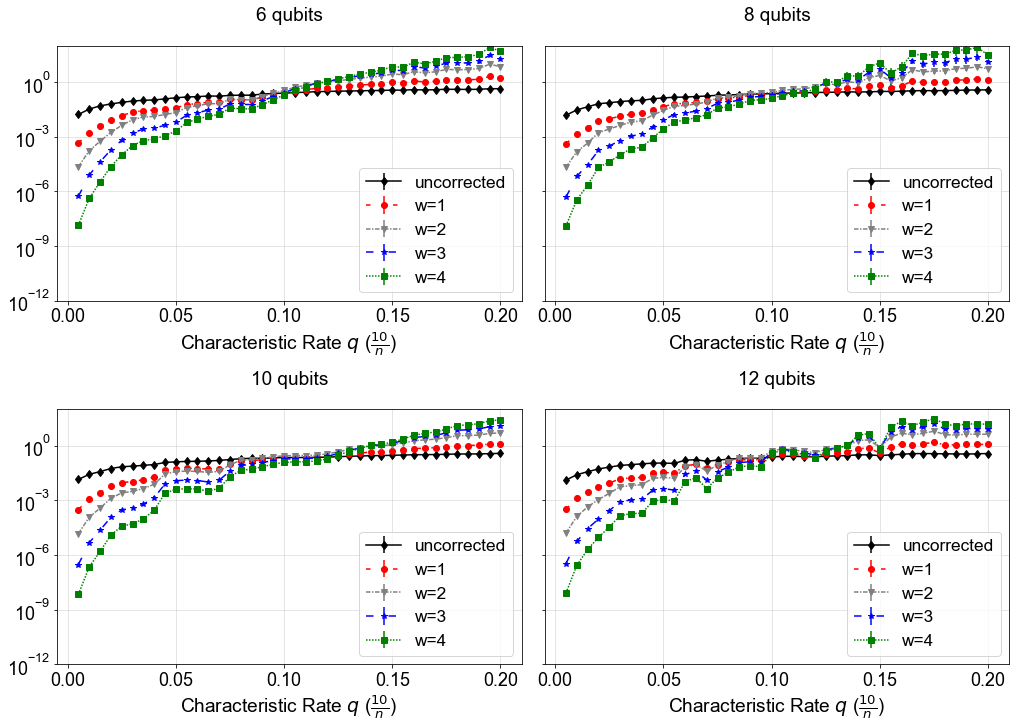

In [18]:
ntrials = 20
qvals = np.linspace(0.005 , 0.2, 40)

plt.style.use('./style.mplstyle')
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True, sharey=True)

x = np.asarray([0] + wvals)

leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = ['s', '*', 'v', 'o', 'd']
colors = ['k', 'r', 'gray', 'b', 'g']

# Second figure: plot trace distance asfu of characteristic q
leglabels = ["uncorrected"] + [f"w={w}" for w in wvals]
linestyles = ["solid", (0, (3, 7, 1, 7)), (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (1, 1))]
markers_2 = list(reversed(markers)) # scramble these to avoid visual continuity

ax_list = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]
n_qubits_list = [6, 8, 10, 12]

for n_qubits, ax in zip(n_qubits_list, ax_list):
    q_outcomes = np.load("{}qubits_scaling_results_4.npy".format(n_qubits))
    q_avg_outcomes = q_outcomes.mean(axis=2)
    q_var_outcomes = q_outcomes.std(axis=2) / np.sqrt(ntrials) # "standard error" = SD / sqrt(ntrials)
    # q_var_outcomes = q_outcomes.std(axis=2) # "standard error" = SD / sqrt(ntrials)
    for j, y in enumerate(q_avg_outcomes):
        confidence = q_var_outcomes[j]
        ax.errorbar(qvals, y, yerr=confidence, label=leglabels[j], marker=markers_2[j], ls=linestyles[j], c=colors[j])
    ax.set_title('{nq} qubits'.format(nq=n_qubits))

# Formatting for both
for ax in ax_list:
    ax.set_xlabel(r"Characteristic Rate $q$ ($\frac{10}{n}$) ")
    ax.legend(leglabels)
    ax.grid(True, alpha=0.4)
    ax.set_ylim(10**-12, 10**2)
    ax.semilogy()


# fig.savefig("figures/figure2.pdf")

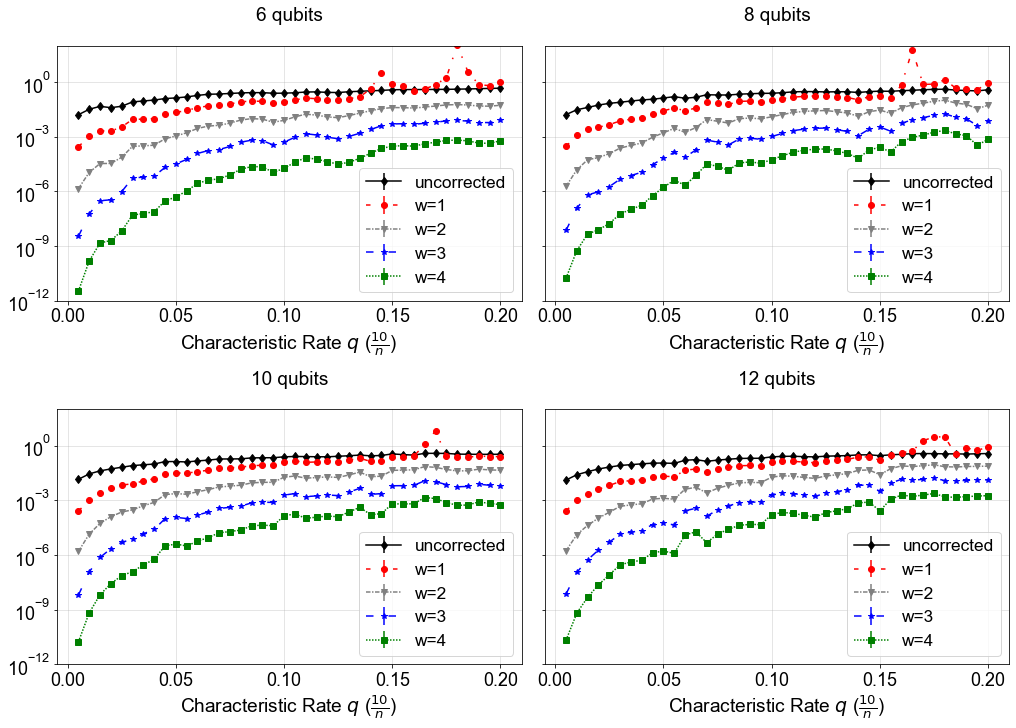

In [17]:
ntrials = 20
qvals = np.linspace(0.005 , 0.2, 40)

plt.style.use('./style.mplstyle')
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True, sharey=True)

x = np.asarray([0] + wvals)

leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = ['s', '*', 'v', 'o', 'd']
colors = ['k', 'r', 'gray', 'b', 'g']

# Second figure: plot trace distance asfu of characteristic q
leglabels = ["uncorrected"] + [f"w={w}" for w in wvals]
linestyles = ["solid", (0, (3, 7, 1, 7)), (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (1, 1))]
markers_2 = list(reversed(markers)) # scramble these to avoid visual continuity

ax_list = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]
n_qubits_list = [6, 8, 10, 12]

for n_qubits, ax in zip(n_qubits_list, ax_list):
    q_outcomes = np.load("{}qubits_scaling_results_4a.npy".format(n_qubits))
    q_avg_outcomes = q_outcomes.mean(axis=2)
    q_var_outcomes = q_outcomes.std(axis=2) / np.sqrt(ntrials) # "standard error" = SD / sqrt(ntrials)
    # q_var_outcomes = q_outcomes.std(axis=2) # "standard error" = SD / sqrt(ntrials)
    for j, y in enumerate(q_avg_outcomes):
        confidence = q_var_outcomes[j]
        ax.errorbar(qvals, y, yerr=confidence, label=leglabels[j], marker=markers_2[j], ls=linestyles[j], c=colors[j])
    ax.set_title('{nq} qubits'.format(nq=n_qubits))

# Formatting for both
for ax in ax_list:
    ax.set_xlabel(r"Characteristic Rate $q$ ($\frac{10}{n}$) ")
    ax.legend(leglabels)
    ax.grid(True, alpha=0.4)
    ax.set_ylim(10**-12, 10**2)
    ax.semilogy()


# fig.savefig("figures/figure2.pdf")

## Two experiments andy

1. First experiment: Fix $q$, then plot $d(p, \tilde{p})$ as a function of $w$ for changing no. qubits
2. Second exeriment: Fix $n$, then plot $d(p, \tilde{p})$ as a function of $q$ for changing w cutoff


In [22]:
import itertools

In [35]:
def trace_dist(a, b):
    # use trace distance for comparing full distributions
    return abs(a - b).sum()

# First experiment
wvals = [1, 2, 3, 4, 5, 6]
nqubits_lst = [6, 8, 10, 12]
qfixed = .06

def slice_for_Rj(n, j):
    """Construct an array slice for all indices corresponding to an Rj cut.

    TODO: could be more efficient taking
    Args:
        n: number of bits
        j: "order" of R_j to compute
    Returns:
        slices: tuple(np.ndarray, np.ndarray) of zipped (x,y) corrdinates, such
            that R[slices] = R_j
    """
    out = []
    d = 1 << n
    for i in range(d):
        for k in range(d):
            if k < i:
                continue
            if utils.distance(i, k) == j:
                out.append((i,k))
    out = np.asarray(list(zip(*out)))
    slices = tuple(np.hstack((out, out[::-1,:])))
    return slices

def invert_pfull_truncated_2(R, p_prime, w1, w2=None):
    """Compute $R^{-1}p'$ using a series truncation.

    Args:
        R: Baseline response matrix.
        p_prime: Probability distribution representing observations WITH errors
        w1: Cutoff for the _infinite_ series for computing A^{-1}
        w2: Cutoff for the decomposition of R into {R_j: j=1, ..., w2}

    Returns:
        p_fixed: output distribution acheived by inverting R up to truncation
            (w1, w2).
    """

    if w2 is None:
        w2 = w1

    d = R.shape[0]
    n = int(np.log2(d))

    R_truncated = np.zeros((d, d), dtype=float)
    for j in range(0, w2 + 1):
        coor = slice_for_Rj(n, j)
        R_truncated[coor] = R[coor]

    p_fixed = np.linalg.inv(R_truncated).dot(p_prime)
    return p_fixed

In [36]:
# Second experiment
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

def run_function(val_in, n_qubits):
    qmax, trial = val_in
    qmax = 10* qmax / n_qubits
    R = response_matrix.generate_characteristic_R(qmax, n_qubits)
    p_true = make_random(n_qubits)
    p_prime = R @ p_true

    # Full distribution correction
    q_outcome = []
    q_outcome.append(trace_dist(p_prime, p_true))
    for k, w in enumerate(wvals):
        p_fixed = invert_pfull_truncated_2(R, p_prime, w1=w, w2=w)
        q_outcome.append(trace_dist(p_fixed, p_true))
    return np.array(q_outcome)

ntrials = 40
qvals = np.linspace(0.02, 0.6, 30)
# n_qubits = 4

for n_qubits in list(range(6, 14, 2)):
    run_list = list(itertools.product(qvals, range(ntrials)))
    outputs = parallel_run(
        run_function, run_list, n_workers=100, retry_switch=False, use_tqdm=True,
        func_kwargs=dict(n_qubits=n_qubits))

    # Outcomes contain truncated result comparisons
    q_outcomes = np.zeros((len(qvals), ntrials, len(wvals) + 1)) # rows correspond to w=0, 1,2...

    run_list_2 = list(itertools.product(range(len(qvals)), range(ntrials)))
    for n, val_in in enumerate(run_list_2):
        j, trial = val_in
        q_outcomes[j, trial] = outputs[n]

    q_outcomes = np.swapaxes(np.swapaxes(q_outcomes, 2, 1), 1, 0)
    np.save("{}qubits_scaling_results_b_0.npy".format(n_qubits), q_outcomes)

100%|██████████| 1.20k/1.20k [00:01<00:00, 810it/s] 
100%|██████████| 1.20k/1.20k [00:23<00:00, 50.2it/s]
100%|██████████| 1.20k/1.20k [06:53<00:00, 2.90it/s] 
100%|██████████| 1.20k/1.20k [3:40:50<00:00, 15.9s/it]  


In [37]:
q_outcomes = np.load("{}qubits_scaling_results_b_0.npy".format(6))

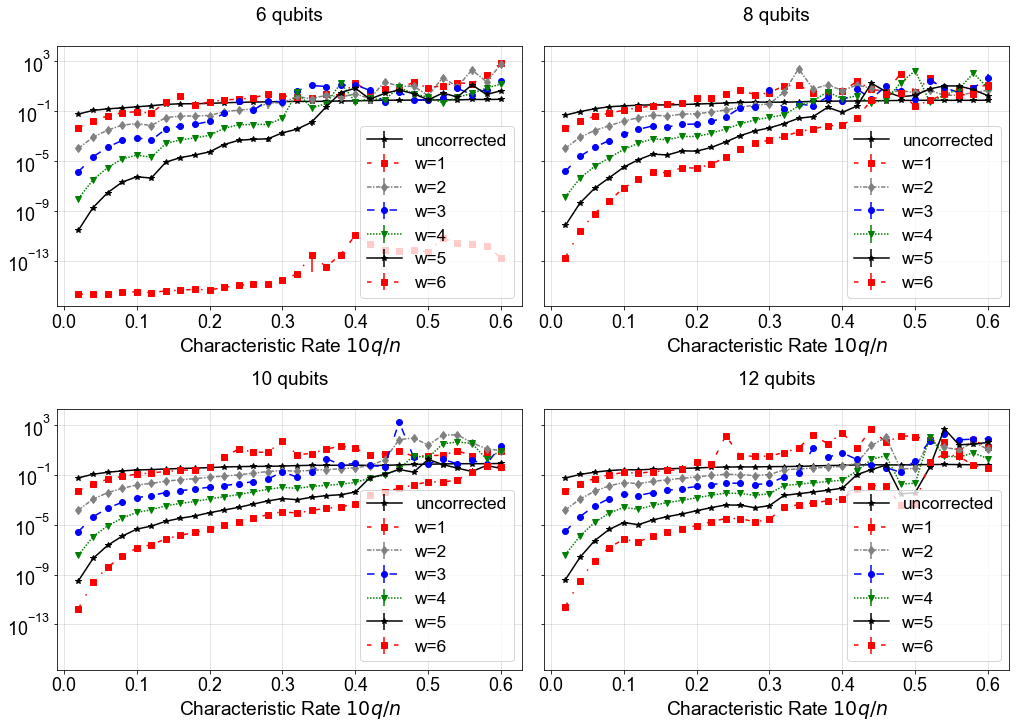

In [43]:
ntrials = 40
qvals = np.linspace(0.02, 0.6, 30)

plt.style.use('./style.mplstyle')
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True, sharey=True)

x = np.asarray([0] + wvals)

leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = ['s', '*', 'v', 'o', 'd', 's', '*']
colors = ['k', 'r', 'gray', 'b', 'g', 'k', 'r']

# Second figure: plot trace distance asfu of characteristic q
leglabels = ["uncorrected"] + [f"w={w}" for w in wvals]
linestyles = ["solid", (0, (3, 7, 1, 7)), (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (1, 1)), "solid", (0, (3, 7, 1, 7))]
markers_2 = list(reversed(markers)) # scramble these to avoid visual continuity

ax_list = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]
n_qubits_list = [6, 8, 10, 12]

for n_qubits, ax in zip(n_qubits_list, ax_list):
    q_outcomes = np.load("{}qubits_scaling_results_b_0.npy".format(n_qubits))
    q_avg_outcomes = q_outcomes.mean(axis=2)
    q_var_outcomes = q_outcomes.std(axis=2) / np.sqrt(ntrials) # "standard error" = SD / sqrt(ntrials)
    # q_var_outcomes = q_outcomes.std(axis=2) # "standard error" = SD / sqrt(ntrials)
    for j, y in enumerate(q_avg_outcomes):
        confidence = q_var_outcomes[j]
        ax.errorbar(qvals, y, yerr=confidence, label=leglabels[j], marker=markers_2[j], ls=linestyles[j], c=colors[j])
    ax.set_title('{nq} qubits'.format(nq=n_qubits))

# Formatting for both
for ax in ax_list:
    ax.set_xlabel(r"Characteristic Rate $10 q / n$")
    ax.legend(leglabels)
    ax.grid(True, alpha=0.4)
    ax.semilogy()


# fig.savefig("figures/figure2.pdf")

# Visualizing distributions

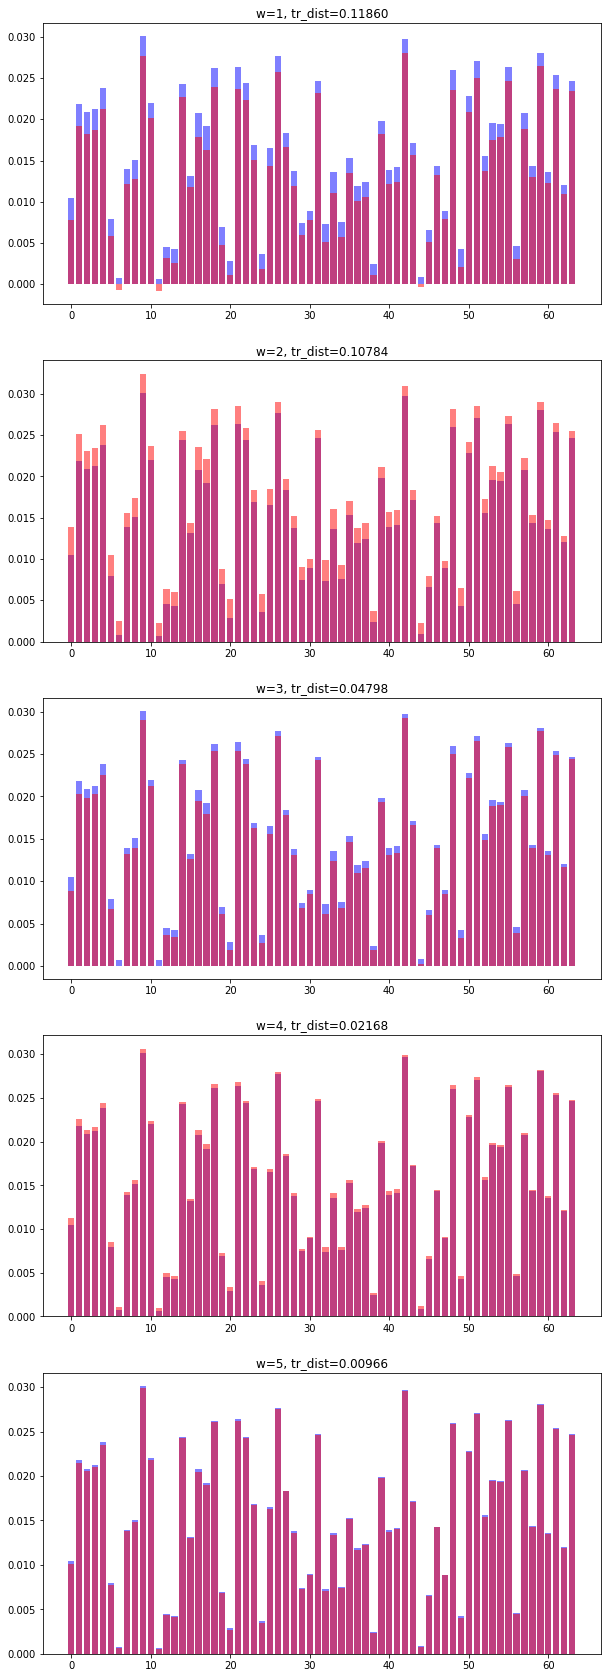

In [11]:
n_qubits = 6
q01_arr = [0.09, .07, 0.12, 0.08, 0.11, 0.06, 0.07, 0.11]
q10_arr = [0.04, .03, .05, 0.04, 0.03, .05, .04, 0.06]
R = response_matrix.Rmatrix(q01_arr[:n_qubits], q10_arr[:n_qubits])
Rinv = np.linalg.inv(R)
p_true = make_random(n_qubits)
p_prime = R @ p_true
x = np.arange(1 << n_qubits)

wvals = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(len(wvals), 1, figsize=(10, 30))
kl_divs = []

for k, w in enumerate(wvals):
    # Empirically i observe that w1,w2 changing independently has little effect on performance
    p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
    axes[k].bar(x, p_true, alpha=0.5, label="true distr", color='b')
    axes[k].bar(x, p_fixed, alpha=0.5, label="fixed distr", color='r')
    
    kl_div = trace_dist(p_fixed, p_true)
    axes[k].set_title(f"w={w}, tr_dist={kl_div:3.5f}")
    kl_divs.append(kl_div)
    

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


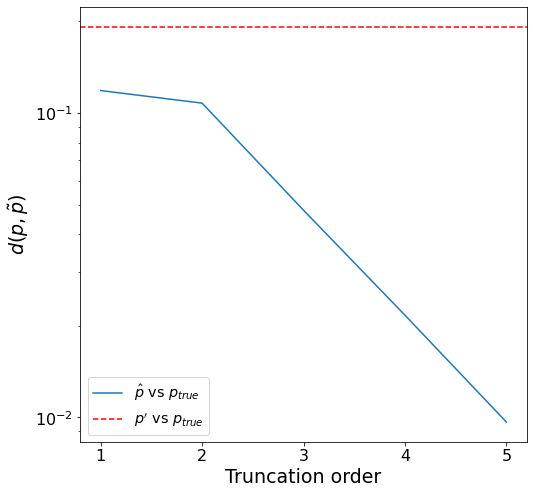

In [12]:
# Plot KL-div as a function of increasing cutoff
plt.style.use('./style.mplstyle')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(wvals, kl_divs, label=r"$\hat{p}$ vs $p_{true}$")

# Compare to no error correction
initial_kl = trace_dist(p_prime, p_true)
ax.axhline(initial_kl, ls='--', c='r', label=r"$p'$ vs $p_{true}$")

# ax.set_title("KL_div vs. cutoff w")
ax.semilogy()
ax.set_xlabel(r"Truncation order")
ax.set_ylabel(r"$d(p, \tilde{p})$")
ax.set_xticks(wvals)
ax.legend(prop={'size': 'x-large'})

None

In [13]:
fig.savefig("figure1.pdf")